In [82]:
from tensorflow import keras
from tensorflow.keras import metrics, regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [88]:
train_file = np.load('../data/shuffled_1D_train.npz')
X_train = train_file['arr_0']
y_train = train_file['arr_1']

val_file = np.load('../data/shuffled_1D_valid.npz')
X_val = val_file['arr_0']
y_val = val_file['arr_1']

test_file = np.load('../data/1D_test_arr_fixed.npz')
X_test = test_file['arr_0']
y_test = test_file['arr_1']

In [90]:
num_classes = 8
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [4]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(6394, 640, 7)
(800, 640, 7)
(800, 640, 7)


# 1D CNN model

In [67]:
model = Sequential()

model.add(Conv1D(128,40, activation='relu', input_shape=(640, 7)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))

model.add(Conv1D(256,20, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))

model.add(Conv1D(512,20, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))

model.add(Flatten())
model.add(Dense(8, activation='softmax', name='final'))
model.compile(loss = keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics = ['accuracy']
)

model.fit(x=X_train, y=y_train,
          batch_size=64,
          epochs=50,
          verbose=1,
          validation_data=(X_val, y_val))

Epoch 1/50
100/100 [==============================] - 13s 127ms/step - loss: 1.9995 - accuracy: 0.3306 - val_loss: 8.4362 - val_accuracy: 0.1375
Epoch 2/50
100/100 [==============================] - 12s 124ms/step - loss: 1.7167 - accuracy: 0.3703 - val_loss: 4.9785 - val_accuracy: 0.1450
Epoch 3/50
100/100 [==============================] - 12s 124ms/step - loss: 1.6459 - accuracy: 0.4010 - val_loss: 2.9252 - val_accuracy: 0.2488
Epoch 4/50
100/100 [==============================] - 12s 123ms/step - loss: 1.6280 - accuracy: 0.4187 - val_loss: 4.6804 - val_accuracy: 0.2225
Epoch 5/50
100/100 [==============================] - 13s 127ms/step - loss: 1.5788 - accuracy: 0.4371 - val_loss: 5.7862 - val_accuracy: 0.1525
Epoch 6/50
100/100 [==============================] - 13s 126ms/step - loss: 1.5142 - accuracy: 0.4606 - val_loss: 5.8950 - val_accuracy: 0.1725
Epoch 7/50
100/100 [==============================] - 13s 128ms/step - loss: 1.5016 - accuracy: 0.4700 - val_loss: 3.1382 - val_ac

In [48]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 601, 128)          35968     
_________________________________________________________________
batch_normalization_45 (Batc (None, 601, 128)          512       
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 150, 128)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 131, 256)          655616    
_________________________________________________________________
batch_normalization_46 (Batc (None, 131, 256)          1024      
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 32, 256)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 13, 512)         

In [80]:
model.save('../1D_CNN_model/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../1D_CNN_model/assets


In [96]:
saved_model = load_model('../1D_CNN_model/')
saved_model.evaluate(X_test, y_test)

25/25 [==============================] - 0s 17ms/step - loss: 4.0636 - accuracy: 0.3313


[4.063586235046387, 0.33125001192092896]

In [91]:
y_pred = saved_model.predict(X_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

array([[35,  7,  8, 14, 13, 15,  5,  3],
       [ 6, 21, 18,  3, 18, 11, 13, 10],
       [ 1, 24, 16,  0, 16, 11, 11, 21],
       [13,  4,  2, 64,  3,  4,  5,  5],
       [ 7, 16, 27,  2, 31,  3,  6,  8],
       [11,  5, 14,  6,  2, 25, 19, 18],
       [10,  3, 13, 24,  9,  9, 22, 10],
       [ 2, 13, 10,  0,  3,  4, 17, 51]])

# 1D CNN-LSTM model

In [5]:
# Establish callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=10, verbose=0, mode='max')
model_checkpoint = ModelCheckpoint('../CNN_LSTM_model/', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

# Compiler parameters
loss = keras.losses.categorical_crossentropy
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
metrics=['accuracy']

In [7]:
model2 = Sequential(name = 'CNN_LSTM_Hybrid')

model2.add(Sequential([
    Conv1D(128,10,
           activation='relu',
           kernel_regularizer=regularizers.l2(0.01),
           input_shape=(640, 7)),
    BatchNormalization(),
    MaxPooling1D(pool_size=4),
    Dropout(0.1)],
           name = 'Conv1'))

model2.add(Sequential([
    Conv1D(256,5,
           activation='relu',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=4),
    Dropout(0.1)],
           name = 'Conv2'))

model2.add(Sequential([
    Conv1D(512,5,
           activation='relu',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=4),
    Dropout(0.1)],
           name = 'Conv3'))

model2.add(Sequential([
    LSTM(350),
    BatchNormalization(),
    Dropout(0.1)],
           name = 'LSTM'))

model2.add(Sequential([
    Dense(64, activation='relu', bias_regularizer=regularizers.l2(1e-4)),
    Dropout(0.2)],
           name = 'Dense1'))

model2.add(Sequential([
    Dense(8, activation='softmax')],
           name = 'Final'))
    
model2.compile(loss =loss,
    optimizer=optimizer,
    metrics = metrics)

history = model2.fit(x=X_train, y=y_train,
                     batch_size=64,
                     epochs=80,
                     verbose=1,
                     validation_data=(X_val, y_val),
                     callbacks=[early_stopping])
                     #, model_checkpoint])

Epoch 1/80
100/100 [==============================] - 11s 108ms/step - loss: 7.2410 - accuracy: 0.3022 - val_loss: 7.2691 - val_accuracy: 0.1338
Epoch 2/80
100/100 [==============================] - 10s 103ms/step - loss: 6.9182 - accuracy: 0.3710 - val_loss: 7.0633 - val_accuracy: 0.2163
Epoch 3/80
100/100 [==============================] - 10s 103ms/step - loss: 6.7851 - accuracy: 0.3944 - val_loss: 6.8073 - val_accuracy: 0.3225
Epoch 4/80
100/100 [==============================] - 10s 103ms/step - loss: 6.7195 - accuracy: 0.3919 - val_loss: 6.6887 - val_accuracy: 0.3587
Epoch 5/80
100/100 [==============================] - 10s 103ms/step - loss: 6.6257 - accuracy: 0.4198 - val_loss: 6.5650 - val_accuracy: 0.3975
Epoch 6/80
100/100 [==============================] - 10s 102ms/step - loss: 6.5735 - accuracy: 0.4154 - val_loss: 6.5569 - val_accuracy: 0.3787
Epoch 7/80
100/100 [==============================] - 10s 103ms/step - loss: 6.4975 - accuracy: 0.4310 - val_loss: 6.4891 - val_ac

100/100 [==============================] - 10s 103ms/step - loss: 4.9896 - accuracy: 0.5895 - val_loss: 5.3659 - val_accuracy: 0.4787
Epoch 58/80
100/100 [==============================] - 10s 104ms/step - loss: 4.9785 - accuracy: 0.5926 - val_loss: 5.4151 - val_accuracy: 0.4663
Epoch 59/80
100/100 [==============================] - 10s 102ms/step - loss: 4.9679 - accuracy: 0.5901 - val_loss: 5.3657 - val_accuracy: 0.4725
Epoch 60/80
100/100 [==============================] - 10s 103ms/step - loss: 4.9308 - accuracy: 0.6026 - val_loss: 5.3881 - val_accuracy: 0.4650
Epoch 61/80
100/100 [==============================] - 10s 103ms/step - loss: 4.9136 - accuracy: 0.6109 - val_loss: 5.3512 - val_accuracy: 0.4775
Epoch 62/80
100/100 [==============================] - 10s 103ms/step - loss: 4.8889 - accuracy: 0.6070 - val_loss: 5.3171 - val_accuracy: 0.4837
Epoch 63/80
100/100 [==============================] - 10s 103ms/step - loss: 4.8669 - accuracy: 0.6065 - val_loss: 5.3556 - val_accurac

In [75]:
model2.summary()

Model: "CNN_LSTM_Hybrid"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Sequential)           (None, 157, 128)          9600      
_________________________________________________________________
Conv2 (Sequential)           (None, 38, 256)           165120    
_________________________________________________________________
Conv3 (Sequential)           (None, 8, 512)            657920    
_________________________________________________________________
LSTM (Sequential)            (None, 350)               1209600   
_________________________________________________________________
Dense1 (Sequential)          (None, 64)                22464     
_________________________________________________________________
Final (Sequential)           (None, 8)                 520       
Total params: 2,065,224
Trainable params: 2,062,732
Non-trainable params: 2,492
_____________________________________

In [98]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10,5)

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Model '+ metric.capitalize())
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend(['train', 'validation'])
    # plt.show()

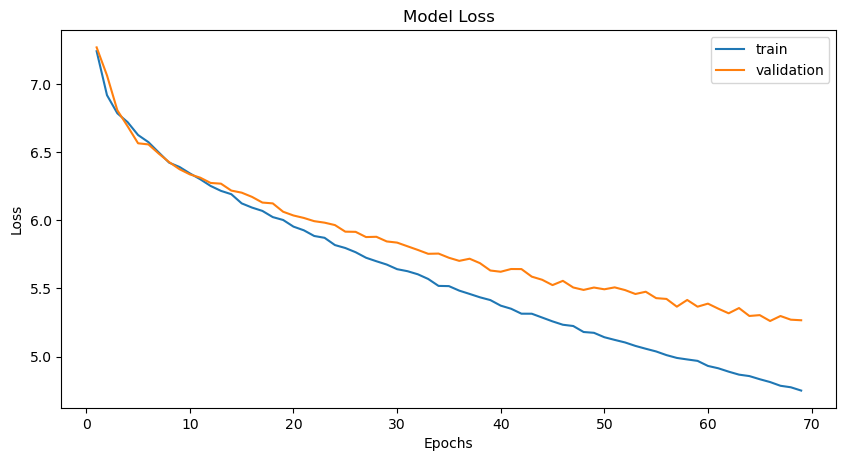

In [100]:
plot_metric(history, 'loss')
plt.savefig('../imgs/model_loss.png')

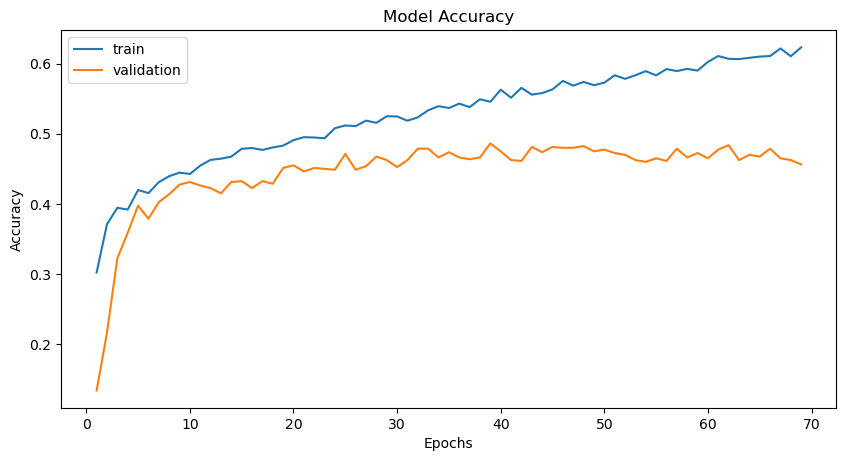

In [101]:
plot_metric(history, 'accuracy')
plt.savefig('../imgs/model_accuracy.png')

In [ ]:
model2.save('../CNN_LSTM_model/')

In [97]:
saved_model = load_model('../CNN_LSTM_model/')
saved_model.evaluate(X_test, y_test)

25/25 [==============================] - 0s 16ms/step - loss: 5.3971 - accuracy: 0.3975


[5.397138595581055, 0.39750000834465027]